<a href="https://colab.research.google.com/github/riyaaaarane/yield-lstm/blob/main/yield_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional , Input
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/content/four-features-all-villages - all_data(5 villages) - Copy of mahalingpur_farm_data_dailyagrre (1).csv.csv", index_col='date', parse_dates=True)

In [38]:
df

,precipitation_mm,temperature_C,lai,fapar,yield,village
date,,,,,,
2007-01-01,0.0,30.035635,11.029443,54.285325,108.25,mahalingpur
2007-01-02,0.0,29.799342,11.143477,54.562126,108.25,mahalingpur
2007-01-03,0.0,29.572417,11.257510,54.838927,108.25,mahalingpur
2007-01-04,0.0,30.142984,11.371544,55.115728,108.25,mahalingpur
2007-01-05,0.0,29.417248,11.485578,55.392530,108.25,mahalingpur
...,...,...,...,...,...,...
2012-12-27,0.0,30.148230,7.581671,44.506220,1839.56,munyal
2012-12-28,0.0,30.560281,7.836705,44.111776,1839.56,munyal
2012-12-29,0.0,32.335009,7.326638,43.717331,1839.56,munyal


In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Sort and drop missing
df = df.dropna()

lags = [1, 2, 7]  # Lag days
rolling_windows = [7, 30]  # Rolling windows

numeric_cols = ['precipitation_mm', 'temperature_C', 'lai', 'fapar', 'yield']

# Lag features
for lag in lags:
    for col in numeric_cols:
        df[f'{col}_lag{lag}'] = df.groupby('village')[col].shift(lag)

# Rolling features
for window in rolling_windows:
    for col in ['precipitation_mm', 'temperature_C', 'lai', 'fapar']:
        df[f'{col}_roll{window}'] = df.groupby('village')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())

df = df.dropna()

# One-hot encode villages
df = pd.get_dummies(df, columns=['village'], drop_first=True)

# Split features and target
feature_cols = [c for c in df.columns if c not in ['yield', 'date']]
X = df[feature_cols].values
y = df['yield'].values.reshape(-1,1)

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences for LSTM
lookback = 90  # 30-day sequence
X_seq, y_seq = [], []

for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i-lookback:i])
    y_seq.append(y_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train-test split
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Define the Bidirectional LSTM model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(256)),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.004, clipnorm=1.0)  # gradient clipping
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics = ['accuracy'] )

#  Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

# Predict and inverse transform
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Evaluate performance
def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return mae, rmse, r2

mae, rmse, r2 = evaluate(y_true, y_pred)
print("Optimized LSTM Performance:")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.0849 - loss: 0.2571 - val_accuracy: 0.0000e+00 - val_loss: 8.8168e-04
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.0940 - loss: 0.0013 - val_accuracy: 0.0000e+00 - val_loss: 5.7817e-04
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.0971 - loss: 8.7590e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0028
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0885 - loss: 0.0013 - val_accuracy: 0.0000e+00 - val_loss: 4.5289e-04
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0935 - loss: 6.8993e-04 - val_accuracy: 0.0000e+00 - val_loss: 5.0930e-04
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.0850 - loss: 6.1572e-04 - val_accuracy: 0.0000e+00 - val_loss: 8.8734e-04
Epoch 7/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.0891 - loss: 8.5181e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0015
Epoch 8/100
217/217 ━━━━━

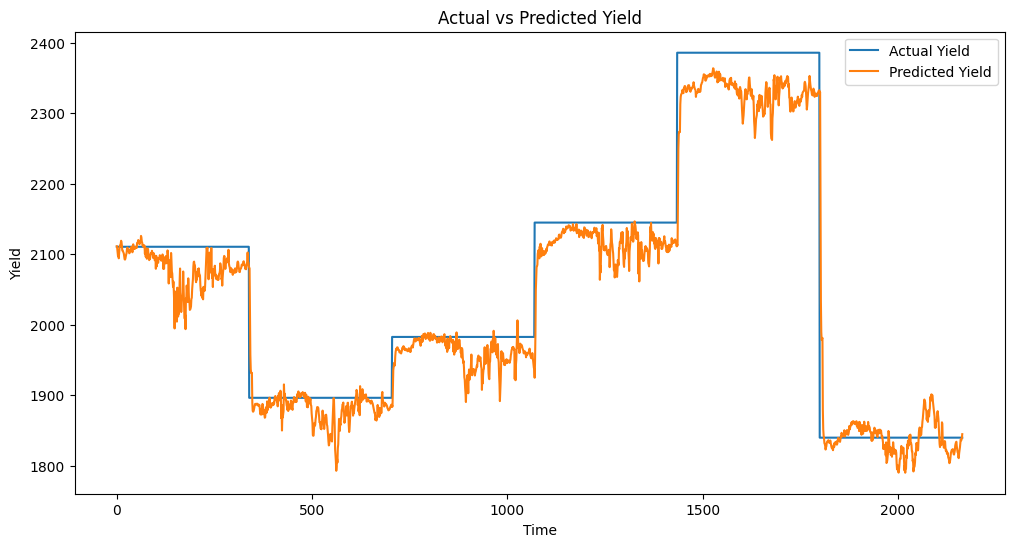

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Yield')
plt.plot(y_pred, label='Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend()
plt.show()